In [85]:
import pandas as pd
import config

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

import pickle
pd.set_option('display.max_rows', None)

In [86]:
df = pd.read_parquet('../data/processed/scores_approvals_2020_2022.parquet')
#df = df[df.course=='DIREITO (BACHARELADO)']
df2 = pd.read_parquet('../data/processed/scores_approvals_2019_2021.parquet')
#df2 = df2[df2.course=='DIREITO (BACHARELADO)']
#df2 = pd.read_parquet('../data/processed/scores_approvals_2019_2021_new.parquet')
approvals_stats = pd.read_parquet('../data/interim/approved_stats_2019_2021.parquet')

In [3]:
approvals_stats[approvals_stats.course.str.contains('ARTES')]

,course,mean,median,min,max
33,ARTES CÊNICAS - INTERPRETAÇÃO TEATRAL (BACHARE...,28.447833,28.447833,27.499000,29.396667
49,ARTES VISUAIS (BACHARELADO),22.134583,24.942083,10.071833,28.582333
55,LICENCIATURA EM ARTES CÊNICAS,22.500833,23.804500,14.542000,29.156000


In [4]:
print(df.shape)
df = pd.merge(df, approvals_stats, on='course', how='left')
print(df.shape)
df['dist_min'] = df['pseudo_argumento_final'] - df['min']
df['dist_max'] = df['pseudo_argumento_final'] - df['max']
df['dist_median'] = df['pseudo_argumento_final'] - df['median']
df['dist_mean'] = df['pseudo_argumento_final'] - df['mean']

(7263, 41)
(7263, 45)


In [5]:
FEATURES = ['escore_bruto_p1_etapa1',
            'escore_bruto_p2_etapa1',
            'nota_redacao_etapa1',
            'escore_bruto_p1_etapa2',
            'escore_bruto_p2_etapa2',
            'nota_redacao_etapa2',
            'escore_bruto_p1_etapa3',
            'escore_bruto_p2_etapa3',
            'nota_redacao_etapa3',
            'pseudo_argumento_final',
            'cotista',
            'cotas_negros_flag',
            'publicas_flag',
            'publicas1_flag',
            'publicas2_flag', 'publicas3_flag', 'publicas4_flag', 'publicas5_flag',
            'publicas6_flag', 'publicas7_flag', 'publicas8_flag',
            #'dist_min',
            #'dist_max',
            #'dist_mean',
            #'dist_median',
            'course'
            ]

In [6]:
len(FEATURES)

22

In [7]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=config.COURSE_NAMES)

In [8]:
df['course'] = df['course'].astype(cat_type)
#df['course'] = df['course'].astype('category')
shuffled_df = df.sample(frac=1, random_state=42)
X = shuffled_df[FEATURES] # features
#X = df[FEATURES] # features
y = shuffled_df['label'] # labels
#y = df['label'] # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47) # 70% training and 30% test

In [9]:
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=47) # 70% training and 30% test

In [10]:
print(X_train.shape)
print(y_train.shape)

(5810, 22)
(5810,)


In [11]:
y_train.value_counts(normalize=True)

0    0.823408
1    0.176592
Name: label, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.814178
1    0.185822
Name: label, dtype: float64

In [13]:
#df2 = df2[df2.course.isin(top3_courses)]

print(df2.shape)
df2 = pd.merge(df2, approvals_stats, on='course', how='left')
print(df2.shape)
df2['dist_min'] = df2['pseudo_argumento_final'] - df2['min']
df2['dist_max'] = df2['pseudo_argumento_final'] - df2['max']
df2['dist_median'] = df2['pseudo_argumento_final'] - df2['median']
df2['dist_mean'] = df2['pseudo_argumento_final'] - df2['mean']

#df2 = df2[df2.label==1]
df2['course'] = df2['course'].astype(cat_type)
df2['course'] = df2['course'].astype('category')
df2_shuffled = df2.sample(frac=1, random_state=42)

(8572, 41)
(8572, 45)


In [14]:
df2_shuffled.label.value_counts()

0    7276
1    1296
Name: label, dtype: int64

In [15]:
X_train = pd.concat([X_train, df2_shuffled[FEATURES]])
y_train = pd.concat([y_train, df2_shuffled['label']])

print(X_train.shape)
print(y_train.shape)

(14382, 22)
(14382,)


In [16]:
y_train.value_counts(normalize=True)

0    0.838548
1    0.161452
Name: label, dtype: float64

In [17]:
#X_train['course'] = X_train['course'].astype("category")
#X_test['course'] = X_test['course'].astype("category")

In [18]:
y_test.value_counts()

0    1183
1     270
Name: label, dtype: int64

In [19]:
X_test.course

982                        CIÊNCIA POLÍTICA (BACHARELADO)
1314                    CIÊNCIAS ECONÔMICAS (BACHARELADO)
4340                   MEDICINA VETERINÁRIA (BACHARELADO)
2356                             ENFERMAGEM (BACHARELADO)
4653                            ODONTOLOGIA (BACHARELADO)
3256                             JORNALISMO (BACHARELADO)
1492    COMUNICAÇÃO SOCIAL - PUBLICIDADE E PROPAGANDA ...
4120                               MEDICINA (BACHARELADO)
1635    DESIGN – PROGRAMAÇÃO VISUAL/PROJETO DO PRODUTO...
3867                               MEDICINA (BACHARELADO)
4688                            ODONTOLOGIA (BACHARELADO)
2541                   ENGENHARIA AMBIENTAL (BACHARELADO)
5353                    QUÍMICA TECNOLÓGICA (BACHARELADO)
6121                               FARMÁCIA (BACHARELADO)
971                        CIÊNCIA POLÍTICA (BACHARELADO)
2363                             ENFERMAGEM (BACHARELADO)
357                 ARQUITETURA E URBANISMO (BACHARELADO)
6610          

## XGBoost

In [20]:
import xgboost as xgb

# Calculate the class imbalance ratio
class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
class_ratio

5.1937984496124034

In [21]:
#Define the XGBoost parameters
# params = {
#     'booster': 'gbtree',
#     'tree_method': 'hist',
#     # 'max_bin': 300,
#      'n_estimators': 390,
#      'eta': 0.01,                        # Learning rate
#     # 'max_depth': 32,                   # Maximum depth of a tree
#      #'subsample': 1,                  # Subsample ratio of the training instances
#     # 'colsample_bytree': 0.7,          # Subsample ratio of columns when constructing each tree
#     # 'scale_pos_weight': class_ratio,
#     # 'gamma': 0.5,
#     # 'lambda': 1
# }

params = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    #'max_bin': 300,
    'n_estimators': 150,
    'eta': 0.1,                        # Learning rate
    'max_depth': 18,                   # Maximum depth of a tree
    'subsample': 0.9,                  # Subsample ratio of the training instances
    #'colsample_bytree': 0.7,          # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': class_ratio,
    #'gamma': 0.5,
    #'lambda': 0
}

# Create an XGBoost classifier
model = xgb.XGBClassifier(**params,
                          #monotone_constraints='(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)',
                          enable_categorical=True)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.9489177489177489,
  'recall': 0.926458157227388,
  'f1-score': 0.9375534644995723,
  'support': 1183},
 '1': {'precision': 0.7080536912751678,
  'recall': 0.7814814814814814,
  'f1-score': 0.7429577464788731,
  'support': 270},
 'accuracy': 0.899518238128011,
 'macro avg': {'precision': 0.8284857200964584,
  'recall': 0.8539698193544347,
  'f1-score': 0.8402556054892227,
  'support': 1453},
 'weighted avg': {'precision': 0.904159802900201,
  'recall': 0.899518238128011,
  'f1-score': 0.9013932140759049,
  'support': 1453}}

In [21]:
#df.course.value_counts()[:15]

In [22]:
#df.groupby(['course', 'label']).size()

In [24]:
#course='ENGENHARIAS – AEROESPACIAL / AUTOMOTIVA / ELETRÔNICA / ENERGIA / SOFTWARE (BACHARELADOS)'
course='DIREITO (BACHARELADO)'
classification_report(y_test[X_test.course==course], y_pred[X_test.course==course], output_dict=True)

{'0': {'precision': 0.9809523809523809,
  'recall': 0.9537037037037037,
  'f1-score': 0.9671361502347416,
  'support': 108},
 '1': {'precision': 0.375,
  'recall': 0.6,
  'f1-score': 0.4615384615384615,
  'support': 5},
 'accuracy': 0.9380530973451328,
 'macro avg': {'precision': 0.6779761904761905,
  'recall': 0.7768518518518519,
  'f1-score': 0.7143373058866016,
  'support': 113},
 'weighted avg': {'precision': 0.9541403286978508,
  'recall': 0.9380530973451328,
  'f1-score': 0.9447645710888886,
  'support': 113}}

In [22]:
unique_course = X_train.course.unique()

for course in unique_course:
    print(course)
    classification_report(y_test[X_test.course==course], y_pred[X_test.course==course], output_dict=True)

CIÊNCIA POLÍTICA (BACHARELADO)
CIÊNCIAS BIOLÓGICAS (BACHARELADO)
CIÊNCIA DA COMPUTAÇÃO (BACHARELADO)
ENFERMAGEM (BACHARELADO)
PSICOLOGIA (BACHARELADO / LICENCIATURA / PSICÓLOGO)
EDUCAÇÃO FÍSICA (LICENCIATURA)
COMUNICAÇÃO SOCIAL – AUDIOVISUAL (BACHARELADO)
DESIGN – PROGRAMAÇÃO VISUAL/PROJETO DO PRODUTO (BACHARELADO)
DIREITO (BACHARELADO)
MEDICINA VETERINÁRIA (BACHARELADO)
TERAPIA OCUPACIONAL (BACHARELADO)
CIÊNCIAS CONTÁBEIS (BACHARELADO)
LICENCIATURA EM FÍSICA
MEDICINA (BACHARELADO)
CIÊNCIAS ECONÔMICAS (BACHARELADO)
RELAÇÕES INTERNACIONAIS (BACHARELADO)
FISIOTERAPIA (BACHARELADO)
ENGENHARIAS – AEROESPACIAL / AUTOMOTIVA / ELETRÔNICA / ENERGIA / SOFTWARE (BACHARELADOS)
CAMPUS UNB CEILÂNDIA (FCE) ENFERMAGEM (BACHARELADO)
FARMÁCIA (BACHARELADO)
ENGENHARIA MECATRÔNICA – CONTROLE E AUTOMAÇÃO (BACHARELADO)
ENGENHARIA AMBIENTAL (BACHARELADO)
ENGENHARIA DE COMPUTAÇÃO (BACHARELADO)
FILOSOFIA (LICENCIATURA)
EDUCAÇÃO FÍSICA (BACHARELADO)
ARTES VISUAIS (BACHARELADO)
JORNALISMO (BACHARELADO)


c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

ENGENHARIA MECÂNICA (BACHARELADO)
BIBLIOTECONOMIA (BACHARELADO)
ODONTOLOGIA (BACHARELADO)
NUTRIÇÃO (BACHARELADO)
SAÚDE COLETIVA (BACHARELADO)
NOTURNO ADMINISTRAÇÃO (BACHARELADO)
CIÊNCIAS AMBIENTAIS (BACHARELADO)
BIOTECNOLOGIA (BACHARELADO)
HISTÓRIA (BACHARELADO/LICENCIATURA )
ENGENHARIA ELÉTRICA (BACHARELADO)
DIURNO ADMINISTRAÇÃO (BACHARELADO)
COMUNICAÇÃO SOCIAL - PUBLICIDADE E PROPAGANDA (BACHARELADO)

c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



QUÍMICA (BACHARELADO)
MATEMÁTICA (BACHARELADO/LICENCIATURA)
COMPUTAÇÃO (LICENCIATURA)
ARQUITETURA E URBANISMO (BACHARELADO)
LÍNGUA E LITERATURA JAPONESA (LICENCIATURA)
LÍNGUA ESPANHOLA E LITERATURA ESPANHOLA E HISPANO - AMERICANA (LICENCIATURA)
MÚSICA (BACHARELADO)
LÍNGUA PORTUGUESA E RESPECTIVA LITERATURA (BACHARELADO/LICENCIATURA)
LICENCIATURA EM ARTES CÊNICAS


c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


FONOAUDIOLOGIA (BACHARELADO)
AGRONOMIA (BACHARELADO)
LETRAS – PORTUGUÊS DO BRASIL COMO SEGUNDA LÍNGUA (LICENCIATURA)
PEDAGOGIA (LICENCIATURA)
LÍNGUA INGLESA E RESPECTIVA LITERATURA (BACHARELADO/LICENCIATURA)
ENGENHARIA DE PRODUÇÃO (BACHARELADO)
ESTATÍSTICA (BACHARELADO)
LÍNGUA PORTUGUESA E RESPECTIVA LITERATURA (LICENCIATURA)
ENGENHARIA FLORESTAL (BACHARELADO)
CIÊNCIAS SOCIAIS – ANTROPOLOGIA / SOCIOLOGIA (BACHARELADO/LICENCIATURA)
ENGENHARIA QUÍMICA (BACHARELADO)
SERVIÇO SOCIAL (BACHARELADO)
GEOLOGIA (BACHARELADO)
FILOSOFIA (BACHARELADO/LICENCIATURA)

c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:


LETRAS – TRADUÇÃO – INGLÊS (BACHARELADO)
ENGENHARIA DE REDES DE COMUNICAÇÃO (BACHARELADO)
COMUNICAÇÃO ORGANIZACIONAL (BACHARELADO)
ARTES VISUAIS (LICENCIATURA)
MUSEOLOGIA (BACHARELADO)
LÍNGUA ESTRANGEIRA APLICADA – MULTILINGUISMO E SOCIEDADE DA INFORMAÇÃO (BACHARELADO)
LICENCIATURA EM CIÊNCIAS BIOLÓGICAS


c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score a

FÍSICA (BACHARELADO)
GEOGRAFIA (BACHARELADO/LICENCIATURA)
ENGENHARIA CIVIL (BACHARELADO)
LICENCIATURA EM QUÍMICA
QUÍMICA TECNOLÓGICA (BACHARELADO)
GESTÃO DE POLÍTICAS PÚBLICAS (BACHARELADO)
MÚSICA (LICENCIATURA)


c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

HISTÓRIA (LICENCIATURA)
GESTÃO AMBIENTAL (BACHARELADO)
CAMPUS UNB PLANALTINA (FUP) – DIURNO CIÊNCIAS NATURAIS (LICENCIATURA)
TURISMO (BACHARELADO)
ARTES CÊNICAS - INTERPRETAÇÃO TEATRAL (BACHARELADO)
ARQUIVOLOGIA (BACHARELADO)
LÍNGUA FRANCESA E RESPECTIVA LITERATURA (BACHARELADO/LICENCIATURA)


c:\Anaconda\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are 

GESTÃO DE AGRONEGÓCIO (BACHARELADO)
LETRAS – TRADUÇÃO – FRANCÊS (BACHARELADO)
LICENCIATURA EM MATEMÁTICA
TEORIA, CRÍTICA E HISTÓRIA DA ARTE (BACHARELADO)
CAMPUS UNB PLANALTINA (FUP) – NOTURNO CIÊNCIAS NATURAIS (LICENCIATURA)
LETRAS – TRADUÇÃO ESPANHOL (BACHARELADO)
GESTÃO DO AGRONEGÓCIO (BACHARELADO)
GEOFÍSICA (BACHARELADO)


c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

In [26]:
# Make predictions on the test set
y_pred = model.predict_proba(X_test)[:, 1] > .5

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.9489177489177489,
  'recall': 0.926458157227388,
  'f1-score': 0.9375534644995723,
  'support': 1183},
 '1': {'precision': 0.7080536912751678,
  'recall': 0.7814814814814814,
  'f1-score': 0.7429577464788731,
  'support': 270},
 'accuracy': 0.899518238128011,
 'macro avg': {'precision': 0.8284857200964584,
  'recall': 0.8539698193544347,
  'f1-score': 0.8402556054892227,
  'support': 1453},
 'weighted avg': {'precision': 0.904159802900201,
  'recall': 0.899518238128011,
  'f1-score': 0.9013932140759049,
  'support': 1453}}

## Features Importance

In [23]:
pd.DataFrame({'x1':model.feature_importances_, 'x2': X_train.columns}).sort_values(['x1'], ascending=False)

,x1,x2
19,0.246580,publicas7_flag
16,0.143984,publicas4_flag
10,0.089464,cotista
21,0.076355,course
15,0.068611,publicas3_flag
20,0.067834,publicas8_flag
14,0.050939,publicas2_flag
17,0.044770,publicas5_flag
18,0.038124,publicas6_flag
9,0.037610,pseudo_argumento_final


## Model Calibration

In [77]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [78]:
model_sigmoid = CalibratedClassifierCV(model, cv=3, method="isotonic")

In [79]:
clf_list = [(model, "XGBoost"), (model_sigmoid, "XGBoost + Isotonic")]

Text(0.5, 1.0, 'Calibration plots (XGBoost)')

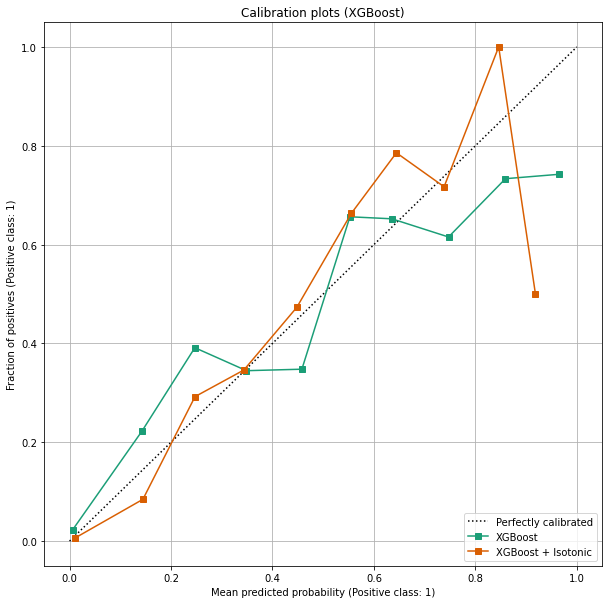

In [80]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (XGBoost)")

In [65]:
# Make predictions on the test set
y_pred = model_sigmoid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.9188524590163935,
  'recall': 0.9475908706677938,
  'f1-score': 0.9330004161464835,
  'support': 1183},
 '1': {'precision': 0.7339055793991416,
  'recall': 0.6333333333333333,
  'f1-score': 0.679920477137177,
  'support': 270},
 'accuracy': 0.8891947694425327,
 'macro avg': {'precision': 0.8263790192077676,
  'recall': 0.7904621020005635,
  'f1-score': 0.8064604466418303,
  'support': 1453},
 'weighted avg': {'precision': 0.8844851792526922,
  'recall': 0.8891947694425327,
  'f1-score': 0.8859724852913475,
  'support': 1453}}

## Prediction for new sample

In [25]:
with open('xgboost_categorical_not_calibrated.pickle','wb') as f:
    pickle.dump(model, f)

In [26]:
with open('../ml_dev/models/xgboost_categorical_calibrated.pickle', 'rb') as f:
  model_loaded = pickle.load(f)

In [39]:
def preprocess_input_features(features: dict) -> pd.DataFrame:
    new_sample = features
    new_sample = pd.DataFrame([new_sample])
    new_sample.course = new_sample.course.astype(cat_type)
    return new_sample

In [81]:
my_sample = {"escore_bruto_p1_etapa1": 5.172,
 "escore_bruto_p2_etapa1": 42.811,
 "nota_redacao_etapa1": 4.691,
 "escore_bruto_p1_etapa2": 6.152,
 "escore_bruto_p2_etapa2": 26.593,
 "nota_redacao_etapa2": 8.966,
 "escore_bruto_p1_etapa3": 3.57,
 "escore_bruto_p2_etapa3": 59.5,
 "nota_redacao_etapa3": 8.908,
 "pseudo_argumento_final": 45.749500000000005,
 "cotista": 0,
 "cotas_negros_flag": 0,
 "publicas_flag": 0,
 "publicas1_flag": 0,
 "publicas2_flag": 0,
 "publicas3_flag": 0,
 "publicas4_flag": 0,
 "publicas5_flag": 0,
 "publicas6_flag": 0,
 "publicas7_flag": 0,
 "publicas8_flag": 0,
 "course": "ARQUITETURA E URBANISMO (BACHARELADO)"}


In [82]:
X_test.loc[357]

escore_bruto_p1_etapa1                                    5.172
escore_bruto_p2_etapa1                                   42.811
nota_redacao_etapa1                                       4.691
escore_bruto_p1_etapa2                                    6.152
escore_bruto_p2_etapa2                                   26.593
nota_redacao_etapa2                                       8.966
escore_bruto_p1_etapa3                                     3.57
escore_bruto_p2_etapa3                                     59.5
nota_redacao_etapa3                                       8.908
pseudo_argumento_final                                  45.7495
cotista                                                       0
cotas_negros_flag                                             0
publicas_flag                                                 0
publicas1_flag                                                0
publicas2_flag                                                0
publicas3_flag                          

In [68]:
y_test

982     0
1314    0
4340    0
2356    0
4653    0
3256    0
1492    0
4120    0
1635    0
3867    0
4688    0
2541    1
5353    1
6121    1
971     0
2363    0
357     1
6610    1
7106    1
3761    0
2230    0
6900    0
2955    0
5156    0
4571    0
1746    0
2759    1
2845    1
1611    0
4099    0
4669    0
2304    0
7028    0
7175    1
2963    0
1352    1
4558    0
703     0
4442    0
5943    0
3355    0
4761    0
1591    0
1630    0
1130    0
6060    0
2280    0
2026    0
2684    0
264     0
3172    0
787     0
3906    0
1464    0
2862    0
6326    0
5530    0
176     0
3980    0
2080    0
4286    0
6751    1
622     1
4580    0
5177    0
5723    0
1797    0
5477    0
4830    0
3171    0
7001    1
3539    0
1520    0
1258    0
6365    0
3721    0
974     0
5799    0
3684    0
4924    0
5514    1
2313    0
1666    0
4706    0
5605    1
1568    0
5302    0
3916    0
2067    0
199     0
1114    0
5811    1
1827    0
6289    1
4100    0
1740    0
7051    0
79      0
643     0
4247    0


In [83]:
my_sample = preprocess_input_features(my_sample)

In [84]:
print(model.predict_proba(my_sample))
print(model_sigmoid.predict_proba(my_sample))
#print(model_sigmoid.predict_proba(X_test.head(13)))

[[0.3819574 0.6180426]]
[[0.55334659 0.44665341]]
